# JAX / FLAX Liberaries

In [ ]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap , pmap
import flax.linen as nn
from flax.training import train_state
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Any , Tuple

# **PRINCIPAL CONFIGURATION**

## Variational Autoencoders (VAE) & Bayesian Neural Networks (BNN)

### Motivation
Standard neural networks produce **point estimates** and are often **overconfident**.
In contrast, **Bayesian models** represent uncertainty by modeling parameters or latent variables as **probability distributions**.

---

### Predictive Distribution
The predictive distribution is given by marginalizing over the weight distribution:

$$
p(y \mid x, \mathcal{D}) = \int p(y \mid x, W)\, p(W \mid \mathcal{D}) \, dW
$$

Since this integral is intractable, we approximate it using **Monte Carlo sampling**.

---


In [ ]:
config = {
    'BATCH_SIZE': 64,
    'LEARNING_RATE': 1e-3,
    'EPOCHS': 15,
    'KL_WEIGHT': 0.0002,
    'MC_SAMPLES': 25,
    'SEED': 42,
    'N_CLASSES': 10
}

#  DATA PIPELINE (FIXED)

In [ ]:
def get_data():
    # Load raw tf.data.Dataset objects
    ds_builder = tfds.builder('fashion_mnist')
    ds_builder.download_and_prepare()

    # Define preprocessing
    def preprocess(batch):
        image = tf.cast(batch['image'], tf.float32) / 255.0
        label = batch['label']
        return {'image': image, 'label': label}

    # Prepare Train (Keep as tf.data.Dataset here to allow re-iteration)
    train_ds = ds_builder.as_dataset(split='train', shuffle_files=True)
    train_ds = train_ds.map(preprocess)
    train_ds = train_ds.shuffle(10000)
    train_ds = train_ds.batch(config['BATCH_SIZE'], drop_remainder=True)
    # Note: We do NOT call tfds.as_numpy() here yet

    # Prepare Test
    test_ds = ds_builder.as_dataset(split='test')
    test_ds = test_ds.map(preprocess)
    test_ds = test_ds.batch(config['BATCH_SIZE'], drop_remainder=True)

    return train_ds, test_ds

# Variational Bayesian Dense Layer




A **Variational Bayesian Dense Layer** is a dense (fully-connected) layer where the weights and biases are treated as **random variables** instead of fixed numbers.  
This allows the network to capture **uncertainty** in its predictions.
![image](https://miro.medium.com/v2/resize:fit:1400/0*G7E7f0KKxeUJBIVO.png)

---

## 1️⃣ Basic Idea

In a standard dense layer:

$$
y = xW + b
$$

In a variational Bayesian layer:

- Weights \(W\) and biases \(b\) are **random variables**.
- We approximate the true posterior with a variational distribution \(q(W)\):

$$
q(W) = \mathcal{N}(\mu, \sigma^2)
$$

$$
q(b) = \mathcal{N}(\mu_b, \sigma_b^2)
$$

---

## 2️⃣ Reparameterization Trick

To allow backpropagation through random sampling, we use:

$$
W = \mu_W + \sigma_W \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, 1)
$$

$$
b = \mu_b + \sigma_b \odot \epsilon_b, \quad \epsilon_b \sim \mathcal{N}(0, 1)
$$

This lets us **sample from the distribution** without breaking the gradient computation.

---

## 3️⃣ KL Divergence (Regularization)

We use **KL divergence** to keep the approximate posterior close to the prior:

$$
p(W) = \mathcal{N}(0,1), \quad p(b) = \mathcal{N}(0,1)
$$

The KL divergence between two Gaussians is:

$$
\text{KL}(q(W) || p(W)) = \frac{1}{2} \sum \Big( \mu_W^2 + \sigma_W^2 - \log(\sigma_W^2) - 1 \Big)
$$

$$
\text{KL}(q(b) || p(b)) = \frac{1}{2} \sum \Big( \mu_b^2 + \sigma_b^2 - \log(\sigma_b^2) - 1 \Big)
$$

The total KL divergence is used as a **regularization term** in the loss.

<img src="https://beehiiv-images-production.s3.amazonaws.com/uploads/asset/file/7ba97b90-d845-47c5-afc8-20892e06b546/KL_Divergence.png?t=1754845514" width="600" height="auto">

---

## 4️⃣ Forward Pass

The forward computation is:

$$
y = xW + b
$$

Where \(W\) and \(b\) are sampled from their approximate posterior distributions.

---

## 5️⃣ Total Loss (ELBO)

During training, we optimize the **Evidence Lower Bound (ELBO)**:

$$
\mathcal{L} = \underbrace{\mathbb{E}_{q(W)}[-\log p(y|x,W)]}_{\text{Data Loss}} +
\underbrace{\text{KL}(q(W)||p(W)) + \text{KL}(q(b)||p(b))}_{\text{Regularization}}
$$

- The first term encourages the network to fit the data.  
- The second term penalizes deviations from the prior, preventing overfitting.



In [ ]:
class VariationalDense(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
        k_mu = self.param('kernal_mu', nn.initializers.glorot_uniform(), (x.shape[-1], self.features))
        k_rho = self.param('kernal_rho', nn.initializers.constant(-3.0), (x.shape[-1], self.features))

        b_mu = self.param('bias_mu', nn.initializers.zeros, (self.features,))
        b_rho = self.param('bias_rho', nn.initializers.constant(-3.0), (self.features,))

        k_sigma = nn.softplus(k_rho)
        b_sigma = nn.softplus(b_rho)

        rng = self.make_rng('reparam')
        k_eps = random.normal(rng, k_mu.shape)
        b_eps = random.normal(rng, b_mu.shape)

        kernal = k_mu + k_sigma * k_eps
        bias = b_mu + b_sigma * b_eps

        # KL Divergence: KL(q||N(0,1))
        kl_loss = 0.5 * jnp.sum(k_mu**2 + k_sigma**2 - jnp.log(k_sigma**2) - 1) + \
                  0.5 * jnp.sum(b_mu**2 + b_sigma**2 - jnp.log(b_sigma**2) - 1)

        self.sow('losses', 'kl_reg', kl_loss)

        return jnp.dot(x, kernal) + bias

## Bayesian Neural Networks (BNN)

### Core Idea
Instead of treating network weights as fixed values, Bayesian Neural Networks model them as **random variables**:

$$
W \sim \mathcal{N}(\mu, \sigma^2)
$$

Each forward pass samples weights from this distribution, producing different outputs and allowing the model to **quantify uncertainty**.

![image](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11053-023-10265-6/MediaObjects/11053_2023_10265_Fig3_HTML.png)


### HYBRID BAYESIAN CNN

In [ ]:
class PrincipalBayesianCNN(nn.Module):
    num_classes: int

    @nn.compact
    def __call__(self, x, training: bool = True):
        # Deterministic Feature Extractor
        x = nn.Conv(32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2,2),strides=(2,2))
        x = nn.Conv(64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2,2),strides=(2,2))
        x = x.reshape((x.shape[0], -1))

        # Probabilistic Head
        x = VariationalDense(128)(x)
        x = nn.relu(x)
        x = VariationalDense(self.num_classes)(x)
        return x

# TRAINING ENGINE (FIXED LOSS AGGREGATION)

In [ ]:
class TrainState(train_state.TrainState):
    pass

def create_train_state(rng, lr):
    model = PrincipalBayesianCNN(num_classes=config['N_CLASSES'])
    dummy_input = jnp.ones([1, 28, 28, 1])
    variables = model.init({'params': rng, 'reparam': rng}, dummy_input)
    tx = optax.adam(lr)
    return TrainState.create(apply_fn=model.apply, params=variables['params'], tx=tx) , model

@jit
def train_step(state, batch, rng):
    def loss_fn(params):
        _, reparam_rng = random.split(rng)

        logits, mutables = state.apply_fn(
            {'params':params},
            batch['image'],
            training=True,
            rngs={'reparam': reparam_rng},
            mutable=['losses']
        )
        # NNL
        one_hot = jax.nn.one_hot(batch['label'], config['N_CLASSES'])
        nnl = optax.softmax_cross_entropy(logits=logits, labels=one_hot).mean()

        # KL Divergence (FIXED: Using tree_leaves)
        kl_losses = jax.tree_util.tree_leaves(mutables['losses'])
        kl_reg =  jnp.sum(jnp.array(kl_losses))

        loss = nnl + (config['KL_WEIGHT'] * kl_reg)
        return loss, (nnl, kl_reg)

    grads, (nll, kl) = jax.grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, nll, kl

# INFERENCE & UNCERTAINTY

### Monte Carlo Approximation
Using \( S \) samples:

$$
p(y \mid x) \approx \frac{1}{S} \sum_{s=1}^{S} p(y \mid x, W^{(s)}),
\quad W^{(s)} \sim q(W)
$$

![image](https://miro.medium.com/0*3N4Ib2a5fsivQR0X.png)

This corresponds to:
```python
MC_SAMPLES = 25
```


In [ ]:
def predict_bayesian(state, images, rng, n_samples=20):
    rng_keys = random.split(rng, n_samples)
    def forward_pass(key):
        logits = state.apply_fn(
            {'params': state.params},
            images,
            training=False,
            rngs={'reparam': key}
        )
        return jax.nn.softmax(logits)

    samples = vmap(forward_pass)(rng_keys) # [Samples, Batch, Classes]
    mean_probs = jnp.mean(samples, axis=0)
    entropy = -jnp.sum(mean_probs * jnp.log(mean_probs + 1e-10), axis=-1)
    return mean_probs, entropy, samples

In [ ]:
def compute_ece(probs, labels, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)

    ece = 0.0
    for i in range(n_bins):
        bin_lower, bin_upper = bin_boundaries[i], bin_boundaries[i+1]
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            accuracy = np.mean(predictions[in_bin] == labels[in_bin])
            avg_confidence = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence - accuracy) * prop_in_bin

    return ece

# EXECUTION (FIXED LOOP)

In [ ]:
print("Initializing Principal Bayesian System...")
rng = random.PRNGKey(config['SEED'])
rng, init_rng = random.split(rng)

# Get tf.data objects
train_ds_obj, test_ds_obj = get_data()

state, model = create_train_state(init_rng, config['LEARNING_RATE'])

Initializing Principal Bayesian System...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.DAVJ2E_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.DAVJ2E_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


#  Training Loop (Corrected)

In [ ]:
print(f"Training on FashionMNIST (Medical Proxy) for {config['EPOCHS']} epochs...")
metrics_history = {'nll': [], 'kl': []}

for epoch in range(config['EPOCHS']):
    batch_nlls, batch_kls = [], []

    train_iter = tfds.as_numpy(train_ds_obj)

    for batch in train_iter:
        rng, step_rng = random.split(rng)
        state, nll, kl = train_step(state, batch, step_rng)
        batch_nlls.append(nll)
        batch_kls.append(kl)

    avg_nll = np.mean(batch_nlls)
    avg_kl = np.mean(batch_kls)

    metrics_history['nll'].append(avg_nll)
    metrics_history['kl'].append(avg_kl)

    print(f"Epoch {epoch+1:02d} | NLL: {avg_nll:.4f} | KL Cost: {avg_kl:.4f}")


Training on FashionMNIST (Medical Proxy) for 15 epochs...
Epoch 01 | NLL: 0.5054 | KL Cost: 853330.6250
Epoch 02 | NLL: 0.3815 | KL Cost: 533100.8125
Epoch 03 | NLL: 0.4044 | KL Cost: 269001.2500
Epoch 04 | NLL: 0.4231 | KL Cost: 102014.1016
Epoch 05 | NLL: 0.4349 | KL Cost: 31351.9102
Epoch 06 | NLL: 0.4395 | KL Cost: 11792.8213
Epoch 07 | NLL: 0.4304 | KL Cost: 6621.9170
Epoch 08 | NLL: 0.4259 | KL Cost: 4714.2349
Epoch 09 | NLL: 0.4187 | KL Cost: 3820.4932
Epoch 10 | NLL: 0.4197 | KL Cost: 3327.3569
Epoch 11 | NLL: 0.4078 | KL Cost: 3012.2200
Epoch 12 | NLL: 0.4065 | KL Cost: 2784.6206
Epoch 13 | NLL: 0.3994 | KL Cost: 2609.4937
Epoch 14 | NLL: 0.3981 | KL Cost: 2465.4270
Epoch 15 | NLL: 0.3947 | KL Cost: 2340.0984


# Evaluation

In [ ]:
print("\n Running Diagnostics & OOD Testing...")
# Prepare Test Data
test_iterator = iter(tfds.as_numpy(test_ds_obj))
test_batch = next(test_iterator)

test_imgs = test_batch['image']
test_lbls = test_batch['label']

rng, infer_rng = random.split(rng)
probs, entropy, _ = predict_bayesian(state, test_imgs, infer_rng, n_samples=config['MC_SAMPLES'])


 Running Diagnostics & OOD Testing...


In [ ]:
# OOD Data (Noise)
ood_imgs = random.normal(infer_rng, test_imgs.shape)
rng, ood_rng = random.split(rng)
ood_probs, ood_entropy, _ = predict_bayesian(state, ood_imgs, ood_rng, n_samples=config['MC_SAMPLES'])

# Visualization

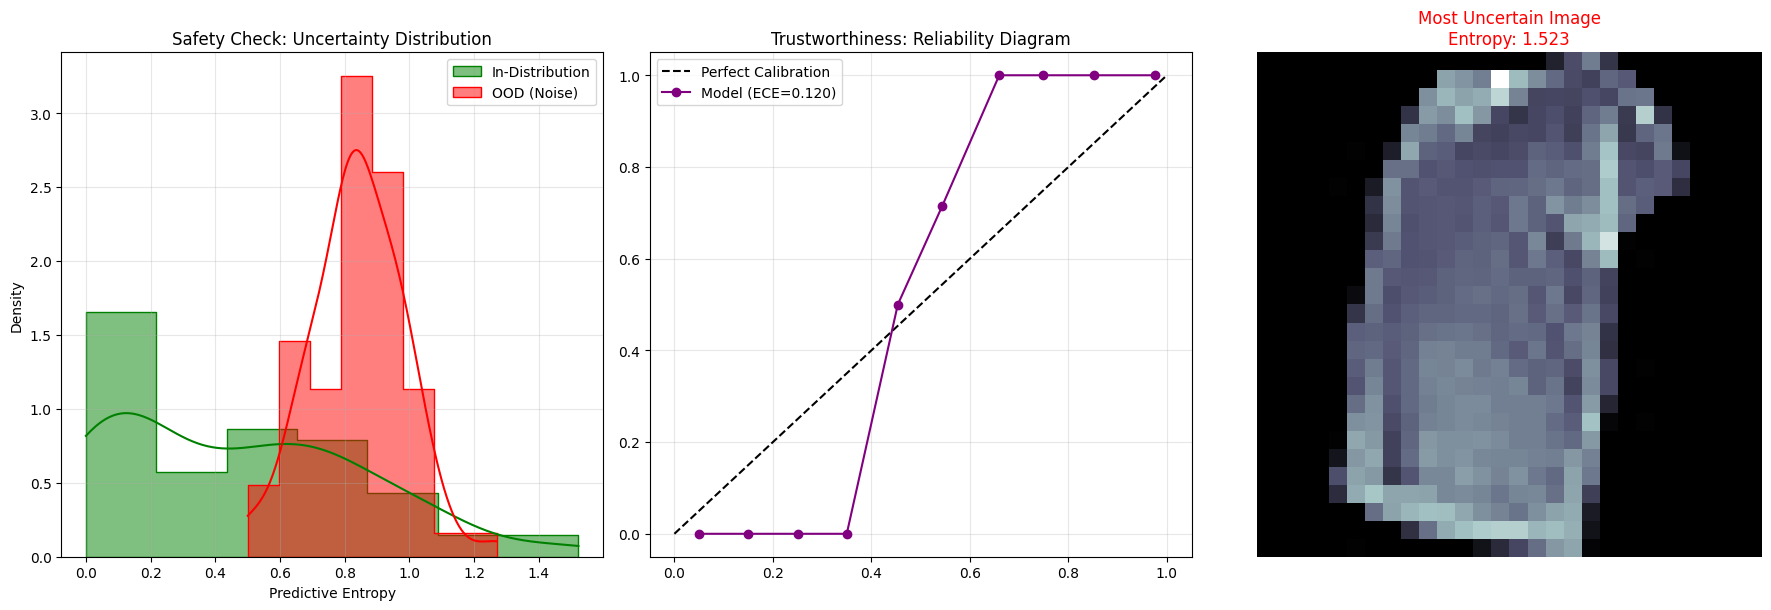


 Final Report:
1. ECE Score: 0.1195
2. KL Cost Converged to: 2340.0984


In [ ]:
plt.figure(figsize=(18, 6))

# Plot 1: Uncertainty Histograms
plt.subplot(1, 3, 1)
sns.histplot(entropy, color='green', label='In-Distribution', kde=True, stat="density", element="step")
sns.histplot(ood_entropy, color='red', label='OOD (Noise)', kde=True, stat="density", element="step")
plt.title("Safety Check: Uncertainty Distribution")
plt.xlabel("Predictive Entropy")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Reliability Diagram
plt.subplot(1, 3, 2)
ece_score = compute_ece(np.array(probs), test_lbls)
confidences = np.max(probs, axis=1)
preds = np.argmax(probs, axis=1)
accuracies = (preds == test_lbls)
bins = np.linspace(0, 1, 11)
bin_accs, bin_confs = [], []
for i in range(len(bins)-1):
    mask = (confidences > bins[i]) & (confidences <= bins[i+1])
    if np.sum(mask) > 0:
        bin_accs.append(np.mean(accuracies[mask]))
        bin_confs.append(np.mean(confidences[mask]))
    else:
        bin_accs.append(0)
        bin_confs.append((bins[i] + bins[i+1])/2)

plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.plot(bin_confs, bin_accs, 'o-', label=f'Model (ECE={ece_score:.3f})', color='purple')
plt.title("Trustworthiness: Reliability Diagram")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Qualitative Analysis
plt.subplot(1, 3, 3)
plt.axis('off')
if len(entropy) > 0:
    top_uncertain_idx = np.argsort(entropy)[-1]
    img_disp = test_imgs[top_uncertain_idx].squeeze()
    plt.imshow(img_disp, cmap='bone')
    plt.title(f"Most Uncertain Image\nEntropy: {entropy[top_uncertain_idx]:.3f}", color='red')

plt.tight_layout()
plt.show()

print(f"\n Final Report:")
print(f"1. ECE Score: {ece_score:.4f}")
print(f"2. KL Cost Converged to: {avg_kl:.4f}")

# Model Evaluation Summary: Uncertainty & Calibration Analysis



This report summarizes the performance of the model regarding **safety (OOD detection)** and **trustworthiness (confidence calibration)**, based on the visualization results.

---

## 1. Safety Check: Uncertainty Distribution

The **Uncertainty Distribution histogram** demonstrates the model's capability to distinguish between known data and anomalies:

- **In-Distribution (Green):**  
  The density peaks at low entropy values, indicating the model is highly confident (low uncertainty) when processing familiar data.

- **OOD / Noise (Red):**  
  The density shifts significantly towards higher entropy values.

**Conclusion:**  
The clear separation between the two distributions suggests a robust safety mechanism.  
The model correctly expresses high uncertainty when encountering Out-of-Distribution (OOD) inputs, minimizing the risk of "silent failures."

---

## 2. Trustworthiness: Reliability Diagram

The **Reliability Diagram** assesses how well the predicted confidence scores align with actual accuracy:

- **Calibration Performance:**  
  The model achieves an **Expected Calibration Error (ECE)** of **0.120**.

- **Observation:**  
  The purple curve deviates from the diagonal "Perfect Calibration" line, particularly in lower confidence regions where the model appears to be under-confident before sharply correcting at higher thresholds.

- **Recommendation:**  
  While the model is functional, applying post-processing techniques like **Temperature Scaling** or **Platt Scaling** could reduce the ECE and align the model's confidence more closely with reality.

---

## 3. Qualitative Analysis: Most Uncertain Sample

The visualized sample represents the input with the **highest predictive uncertainty**:

- **Entropy:** 1.523  
- **Visual Appearance:** Ambiguous and noisy

**Interpretation:**  
This confirms that the calculated entropy is semantically meaningful—the model is most "confused" by inputs that are objectively difficult to classify.

---

## Overall Verdict

- The model is **safe**: effectively flags unknown or OOD inputs.  
- The model requires **minor calibration** to improve the interpretability of its confidence scores.
